Step 1: Get video data from Playstation's Youtube channel

In [ ]:
# !pip3 install --upgrade google-api-python-client

In [19]:
!pip3 install isodate

In [3]:
# # Pretty-print JSON response
# print(json.dumps(response, indent=4))  # Prints in readable format

# # Display formatted JSON in Jupyter Notebook
# JSON(response)

In [25]:
from googleapiclient.discovery import build
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import ticker
import json
from IPython.display import JSON

from google.colab import userdata
api_key = userdata.get('brian-youtube-api-key')

In [5]:
channel_ids = ['playstation',
               # more channels here
               ]

In [6]:
# Define API service name and version
api_service_name = "youtube"
api_version = "v3"

# Get creds and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key
)

In [7]:
def get_channel_stats(youtube, channel_ids):

  all_data = []

  request = youtube.channels().list(
      part="snippet,contentDetails,statistics",
      forHandle=','.join(channel_ids)
  )
  response = request.execute()

  # loop through items
  for item in response['items']:
    data = {'channelName': item['snippet']['title'],
            'subscribers': item['statistics']['subscriberCount'],
            'views': item['statistics']['viewCount'],
            'totalViews': item['statistics']['videoCount'],
            'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
            }
    all_data.append(data)

  return(pd.DataFrame(all_data))

In [8]:
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,subscribers,views,totalViews,playlistId
0,PlayStation,16100000,5532508848,24181,UU-2Y8dQb0S6DtpxNgAKoJKA


In [9]:
playlist_id = "UU-2Y8dQb0S6DtpxNgAKoJKA"

def get_video_ids(youtube, playlist_id):

  video_ids = []

  request = youtube.playlistItems().list(
      part="snippet,contentDetails",
      playlistId=playlist_id,
      maxResults = 50
  )

  response = request.execute()

  for item in response ['items']:
    video_ids.append(item['contentDetails']['videoId'])

  next_page_token = response.get('nextPageToken')
  while next_page_token is not None:
      request = youtube.playlistItems().list(
          part='contentDetails',
          playlistId = playlist_id,
          maxResults = 50,
          pageToken = next_page_token)
      response = request.execute()

      for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

      next_page_token = response.get('nextPageToken')

  return video_ids

In [10]:
video_ids = get_video_ids(youtube, playlist_id)

In [11]:
len(video_ids)

20000

In [12]:
def get_video_details(youtube, video_ids):

  all_video_info = []

  for i in range(0, len(video_ids), 50):
    request = youtube.videos().list(
        part="snippet,contentDetails,statistics",
        id=','.join(video_ids[i:i+50])
    )
    response = request.execute()

    for video in response['items']:
      stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                      'statistics': ['viewCount', 'likeCount', 'favoriteCount', 'commentCount'],
                      'contentDetails': ['duration', 'definition', 'caption']
                      }
      video_info = {}
      video_info['video_id'] = video['id']

      for k in stats_to_keep.keys():
        for v in stats_to_keep[k]:
          try:
            video_info[v] = video[k][v]
          except:
            video_info[v] = None

      all_video_info.append(video_info)

  return pd.DataFrame(all_video_info)

In [13]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption
0,OnOeud6QvOE,PlayStation,Islanders: New Shores - Announce Trailer | PS5...,"Coming to PlayStation this summer, ISLANDERS: ...","[PlayStation, PS5, video games, next gen, Sony...",2025-02-28T20:00:15Z,23,10,0,0,PT1M26S,hd,true
1,DDbPy56gi9Y,PlayStation,Sanguis Luna - Official Trailer | PS5 & PC Games,https://store.playstation.com/concept/10012584...,"[PlayStation, PS5, video games, next gen, Sony...",2025-02-28T17:45:02Z,5010,293,0,45,PT1M43S,hd,true
2,TCWLgmVCMzI,PlayStation,PlayStation: The Concert - Behind the Scenes,https://www.playstation.com/en-us/theconcert/\...,"[PlayStation, PS5, video games, next gen, Sony...",2025-02-28T16:00:37Z,5636,478,0,51,PT3M52S,hd,true
3,lXHTVOMjZH0,PlayStation,Disney Epic Mickey: Rebrushed - Immersion Trai...,https://www.playstation.com/games/disney-epic-...,"[PlayStation, PS5, video games, next gen, Sony...",2025-02-28T14:15:04Z,13805,758,0,55,PT39S,hd,false
4,uGrtpUoXr_w,PlayStation,Monster Hunter Wilds is out now on PS5! Here's...,"Hunters, gather ‘round for a special Monster H...","[PlayStation, PS5, video games, next gen, Sony]",2025-02-28T14:01:07Z,6353,812,0,43,PT1M3S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Z9XGs6xixuE,PlayStation,Publicité officielle de PlayStation pour la pé...,https://www.playstation.com/fr-ca/games/star-w...,"[Star Wars Battle Front, Star Wars PS4, new St...",2015-10-22T19:23:27Z,60057,154,0,4,PT1M1S,hd,false
19996,qSE-R-3drxs,PlayStation,Assassin’s Creed Syndicate - London Calling Tr...,http://bit.ly/1jWuqRR\n\nAssassin’s Creed Synd...,"[assassin's creed syndicate, London Calling, T...",2015-10-22T18:31:14Z,94073,2218,0,194,PT41S,hd,false
19997,WSzscK6KhTs,PlayStation,Assassin’s Creed Syndicate - Gang 101 Trailer ...,https://www.playstation.com/en-us/games/assass...,"[Assassin’s Creed Syndicate, 101, Launch, Gang...",2015-10-22T17:10:04Z,102386,2447,0,251,PT3M20S,hd,false
19998,mBa2dF-OhBE,PlayStation,Deus Ex: Mankind Divided - Adam Jensen 2.0 Tra...,https://www.playstation.com/en-us/games/deus-e...,"[Deus Ex, Mankind Divided, Human Revolution, A...",2015-10-22T16:34:28Z,207298,4289,0,366,PT2M9S,hd,false


Step 2: Perform EDA to understand the following..
* Views per video
* Likes and comments vs. views
* Title length vs. views
* Video duration
* Video upload schedules

In [14]:
video_df.isnull().any()

,0
video_id,False
channelTitle,False
title,False
description,False
tags,True
publishedAt,False
viewCount,False
likeCount,True
favoriteCount,False
commentCount,True


In [15]:
video_df.dtypes

,0
video_id,object
channelTitle,object
title,object
description,object
tags,object
publishedAt,object
viewCount,object
likeCount,object
favoriteCount,object
commentCount,object


In [16]:
numeric_cols = ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [17]:
from dateutil import parser

# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("A"))

In [20]:
# Convert duration to seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [21]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,0 days 00:01:26,PT1M26S
1,0 days 00:01:43,PT1M43S
2,0 days 00:03:52,PT3M52S
3,0 days 00:00:39,PT39S
4,0 days 00:01:03,PT1M3S
...,...,...
19995,0 days 00:01:01,PT1M1S
19996,0 days 00:00:41,PT41S
19997,0 days 00:03:20,PT3M20S
19998,0 days 00:02:09,PT2M9S


In [22]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [23]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favoriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagCount
0,OnOeud6QvOE,PlayStation,Islanders: New Shores - Announce Trailer | PS5...,"Coming to PlayStation this summer, ISLANDERS: ...","[PlayStation, PS5, video games, next gen, Sony...",2025-02-28 20:00:15+00:00,23.0,10.0,0.0,0.0,PT1M26S,hd,true,A,0 days 00:01:26,15
1,DDbPy56gi9Y,PlayStation,Sanguis Luna - Official Trailer | PS5 & PC Games,https://store.playstation.com/concept/10012584...,"[PlayStation, PS5, video games, next gen, Sony...",2025-02-28 17:45:02+00:00,5010.0,293.0,0.0,45.0,PT1M43S,hd,true,A,0 days 00:01:43,34
2,TCWLgmVCMzI,PlayStation,PlayStation: The Concert - Behind the Scenes,https://www.playstation.com/en-us/theconcert/\...,"[PlayStation, PS5, video games, next gen, Sony...",2025-02-28 16:00:37+00:00,5636.0,478.0,0.0,51.0,PT3M52S,hd,true,A,0 days 00:03:52,14
3,lXHTVOMjZH0,PlayStation,Disney Epic Mickey: Rebrushed - Immersion Trai...,https://www.playstation.com/games/disney-epic-...,"[PlayStation, PS5, video games, next gen, Sony...",2025-02-28 14:15:04+00:00,13805.0,758.0,0.0,55.0,PT39S,hd,false,A,0 days 00:00:39,41
4,uGrtpUoXr_w,PlayStation,Monster Hunter Wilds is out now on PS5! Here's...,"Hunters, gather ‘round for a special Monster H...","[PlayStation, PS5, video games, next gen, Sony]",2025-02-28 14:01:07+00:00,6353.0,812.0,0.0,43.0,PT1M3S,hd,false,A,0 days 00:01:03,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Z9XGs6xixuE,PlayStation,Publicité officielle de PlayStation pour la pé...,https://www.playstation.com/fr-ca/games/star-w...,"[Star Wars Battle Front, Star Wars PS4, new St...",2015-10-22 19:23:27+00:00,60057.0,154.0,0.0,4.0,PT1M1S,hd,false,A,0 days 00:01:01,3
19996,qSE-R-3drxs,PlayStation,Assassin’s Creed Syndicate - London Calling Tr...,http://bit.ly/1jWuqRR\n\nAssassin’s Creed Synd...,"[assassin's creed syndicate, London Calling, T...",2015-10-22 18:31:14+00:00,94073.0,2218.0,0.0,194.0,PT41S,hd,false,A,0 days 00:00:41,5
19997,WSzscK6KhTs,PlayStation,Assassin’s Creed Syndicate - Gang 101 Trailer ...,https://www.playstation.com/en-us/games/assass...,"[Assassin’s Creed Syndicate, 101, Launch, Gang...",2015-10-22 17:10:04+00:00,102386.0,2447.0,0.0,251.0,PT3M20S,hd,false,A,0 days 00:03:20,5
19998,mBa2dF-OhBE,PlayStation,Deus Ex: Mankind Divided - Adam Jensen 2.0 Tra...,https://www.playstation.com/en-us/games/deus-e...,"[Deus Ex, Mankind Divided, Human Revolution, A...",2015-10-22 16:34:28+00:00,207298.0,4289.0,0.0,366.0,PT2M9S,hd,false,A,0 days 00:02:09,7


<ipython-input-30-3c985cc3ece2>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


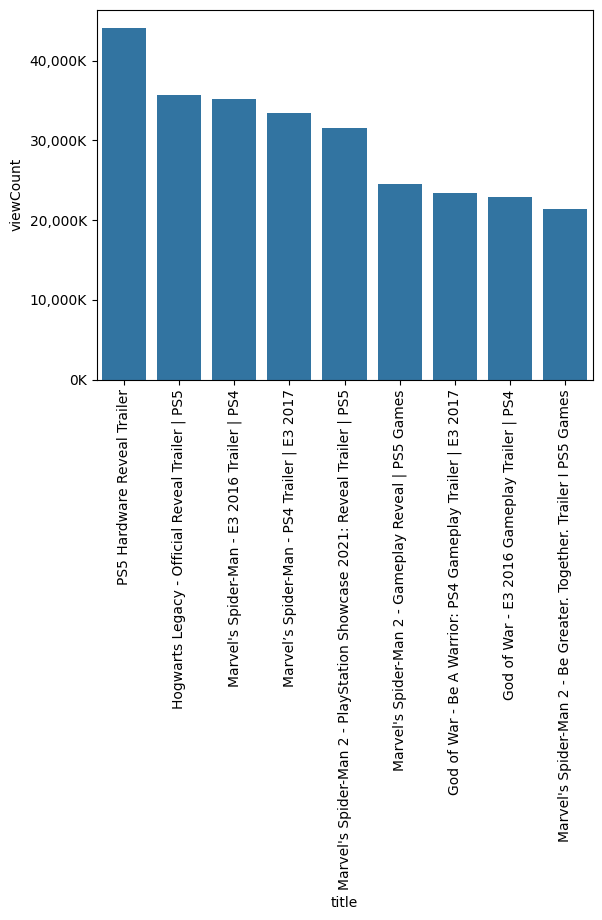

In [30]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

<ipython-input-31-b4df93d8e6f5>:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


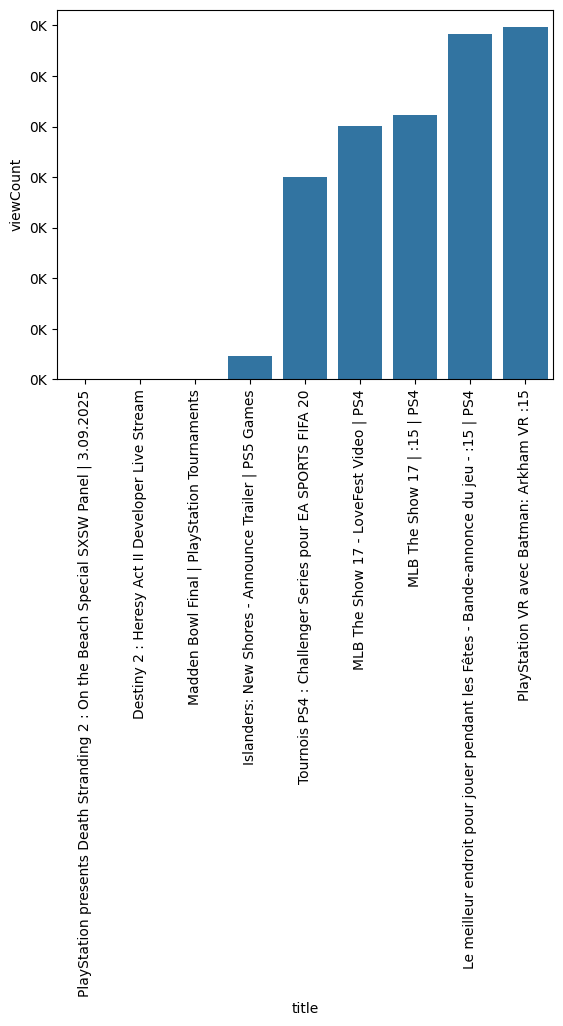

In [31]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending = True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

In [ ]:
plt.figure(figsize=(12,6))
sns.violinplot(x='title', y='viewCount', data=video_df)
plt.xticks(rotation=90)
plt.show()